In [66]:
from collections import deque
import torch
torch.manual_seed(1)
import numpy as np
import ddpg
from importlib import reload
reload(ddpg)
from ddpg import DDPG
import matplotlib.pyplot as plt

In [67]:
#make it generalizable to any number of weights
def calc_reward(w, x, num_tunnels):
  cost = -0.1 * torch.dot(w, x[num_tunnels:num_tunnels*2])
  net_perf = torch.dot(w, x[0:num_tunnels])
  # return (user_pref + cost + net_perf).item()
  # return -torch.max(w).item()# for case where user pref and cost are equal
  #have to reindex w according to user preferences in input before doing this
  # ordered = []
  # for i in range(num_tunnels):
  #   ordered.append((x[num_tunnels*2+i], w[i]))
  # ordered.sort(key=lambda x: x[1], reverse=True)
  # user_pref = -torch.sum(w)
  # for i in range(num_tunnels):
  #   if ordered[i][0] == i+1:
  #     user_pref += ordered[i][1]
  # user_pref = torch.sum(user_pref)
  err = torch.abs(w - x[num_tunnels*2:num_tunnels*3])
  user_pref = -torch.sum(err)
  # print(err, torch.sum(err))
  # print("net_perf: ", net_perf.item(), "user_pref: ", user_pref.item(), "cost: ", cost.item())
  return net_perf + cost + user_pref
  return net_perf + cost #when user pref is all equal

In [68]:
# problem parameters
num_tunnels = 4
state_dim = 3 * num_tunnels
action_dim = 1 * num_tunnels

num_agents = 20

# hyperparameters
hidden_dim = 12
batch_size = 256
actor_lr = 1e-4
critic_lr = 2e-4
tau = 0.001
gamma = 0.9
epsilon = 0.1
# use Gaussian noise?
noise_scale = 0.5*torch.randn(action_dim)
# noise_scale = 0.5
noise_decay = 0.998

episodes = 300
max_steps = 300

In [69]:
# intialize learning agent
agent = DDPG(state_dim, action_dim, hidden_dim=hidden_dim, buffer_size=8000, batch_size=batch_size,
                actor_lr=actor_lr, critic_lr=critic_lr, tau=tau, gamma=gamma)
cost = torch.FloatTensor([10,10,40,40])
user_pref  = torch.FloatTensor([0.4,0.4,0.1,0.1])
fixed_x = torch.cat((cost, user_pref)) # first row for costs, second is preference

rewards_window = deque(maxlen=100)
rewards = []
actor_losses = []
critic_losses = []
states = []
actions = []

for episode in range(episodes):
     # agent_rewards = np.zeros(num_agents)
     tot_reward = 0
     performance_raw_weights = torch.rand(1,num_tunnels)[0]
     state = torch.cat((performance_raw_weights, fixed_x))
     # state = performance_raw_weights
     actor_step_losses = []
     critic_step_losses = []
     past_reward = 0
     for steps in range(max_steps):
          action = agent.act(state, noise_scale)
          #action = state
          #print(action, state)
          #action = agent.actor.forward(state)
          #print(action.requires_grad, state.requires_grad)
          reward = calc_reward(action, state, num_tunnels=4) 
          # reward = curr_reward - past_reward
          # past_reward = curr_reward
          done = int(steps == max_steps - 1)
          performance_raw_weights = torch.rand(1, num_tunnels)[0]
          # performance_raw_weights = torch.tensor([0.,0,0,0])
          # performance_raw_weights[steps % 4] = 1.
          new_x = torch.tensor(fixed_x)
          # new_x[steps % num_tunnels] -= 1
          next_state = torch.cat((performance_raw_weights, new_x))
          # next_state = performance_raw_weights
          # for i in range(num_agents):
          #      agent.store_transition(state, action, reward, next_state, done)
          # agent.store_transition(state, action, reward, next_state, done)
          #actor_loss, critic_loss = agent.learn()
          #actor_loss = -reward*epsilon
          actor_loss = -reward
          agent.actor.optimizer.zero_grad()
          actor_loss.backward()
          agent.actor.optimizer.step()

          if actor_loss is not None:
               actor_step_losses.append(actor_loss.detach().numpy())
               #critic_step_losses.append(critic_loss.detach().numpy())
          
          state = next_state
          # agent_rewards += reward.detach().numpy()
          tot_reward += reward.detach().numpy()
          noise_scale *= noise_decay
     
     states.append(performance_raw_weights.detach().numpy())
     actions.append(action.detach().numpy())
     avg_reward = tot_reward / max_steps
     rewards_window.append(avg_reward)
     rewards.append(avg_reward)

     if actor_step_losses:
          actor_losses.append(np.mean(actor_step_losses))
          critic_losses.append(np.mean(critic_step_losses))

     if episode % 10 == 0:
          print(action)
          print(f'Episode {episode}, Reward: {avg_reward:.2f}, Avg Reward: {np.mean(rewards_window):.2f}')
     
#save final network
torch.save(agent.actor.state_dict(), 'final_models/actor_final.pth')
torch.save(agent.critic.state_dict(), 'final_models/critic_final.pth')

#still can do a little bit better with exploitation/exploration --not reaching global max
#focus on getting the other graphs down that I need and look into explainability before meeting today
#also understand all the code

/var/folders/wj/snljbr_n3_3d9zsdj1_55hkm0000gn/T/ipykernel_2115/40955591.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_x = torch.tensor(fixed_x)


tensor([0.4060, 0.4046, 0.0342, 0.1552], grad_fn=<DivBackward0>)
Episode 0, Reward: -2.13, Avg Reward: -2.13
tensor([5.6924e-01, 4.2906e-01, 4.6404e-04, 1.2355e-03],
       grad_fn=<DivBackward0>)
Episode 10, Reward: -0.90, Avg Reward: -1.04
tensor([4.9249e-01, 5.0722e-01, 6.3003e-05, 2.3104e-04],
       grad_fn=<DivBackward0>)
Episode 20, Reward: -0.90, Avg Reward: -0.97
tensor([5.2058e-01, 4.7933e-01, 1.7047e-05, 6.9090e-05],
       grad_fn=<DivBackward0>)
Episode 30, Reward: -0.89, Avg Reward: -0.95
tensor([5.3705e-01, 4.6293e-01, 4.1301e-06, 1.8370e-05],
       grad_fn=<DivBackward0>)
Episode 40, Reward: -0.89, Avg Reward: -0.93
tensor([4.2870e-01, 5.7129e-01, 9.4965e-07, 5.9984e-06],
       grad_fn=<DivBackward0>)
Episode 50, Reward: -0.88, Avg Reward: -0.92
tensor([5.8331e-01, 4.1669e-01, 2.1988e-07, 9.5760e-07],
       grad_fn=<DivBackward0>)
Episode 60, Reward: -0.86, Avg Reward: -0.92
tensor([4.1766e-01, 5.8234e-01, 5.0147e-08, 3.2262e-07],
       grad_fn=<DivBackward0>)
Episo

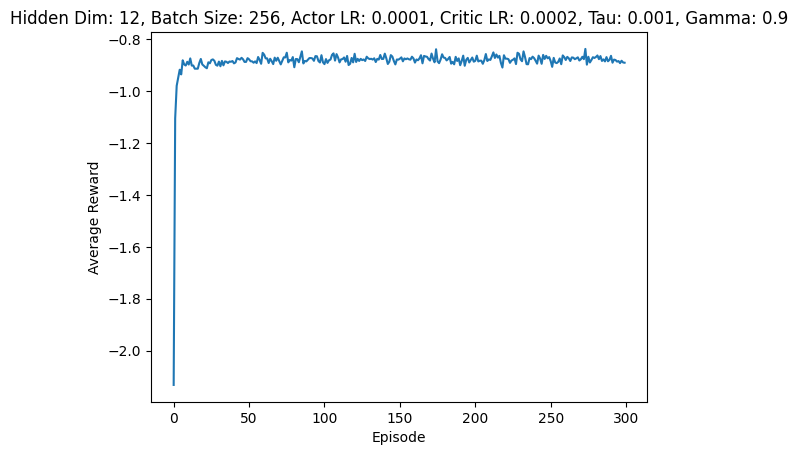

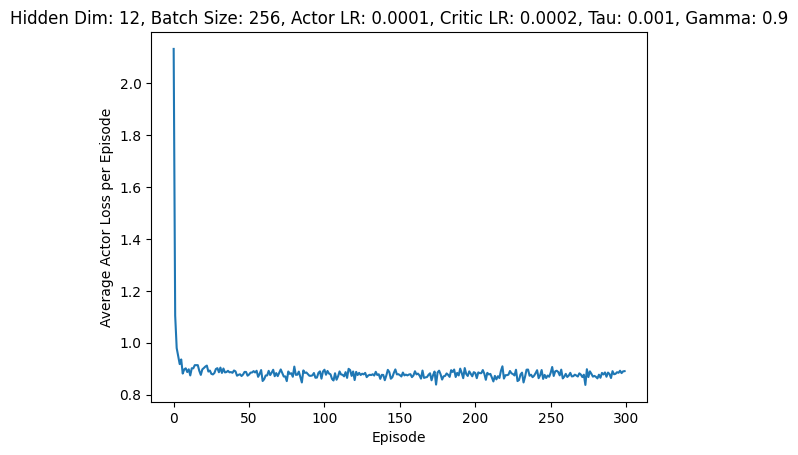

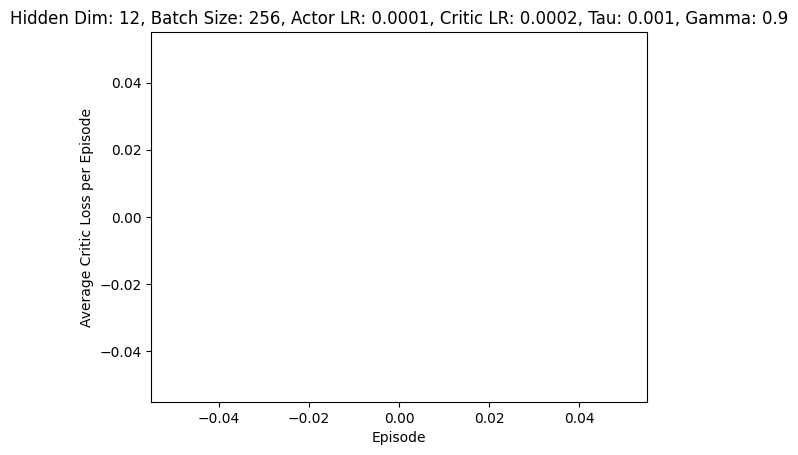

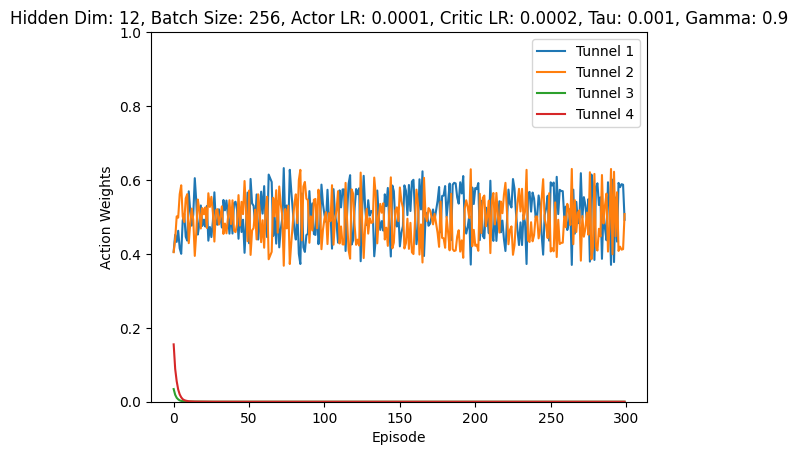

In [70]:
# make the scales uniform for graphs of the same type (possible to increase the size of the labels)
hyperparameter_title = f'Hidden Dim: {hidden_dim}, Batch Size: {batch_size}, Actor LR: {actor_lr}, Critic LR: {critic_lr}, Tau: {tau}, Gamma: {gamma}'
# plot reward
rewards_graph = rewards
plt.plot(rewards_graph)
plt.ylabel('Average Reward')
plt.xlabel('Episode')
plt.title(hyperparameter_title)
plt.show()

# plot actor loss
plt.plot(actor_losses)
plt.ylabel('Average Actor Loss per Episode')
plt.xlabel('Episode')
plt.title(hyperparameter_title)
plt.show()

# plot actor loss
plt.plot(critic_losses)
plt.ylabel('Average Critic Loss per Episode')
plt.xlabel('Episode')
plt.title(hyperparameter_title)
plt.show()

# plot actions
actions = np.array(actions)
plt.plot(actions[:,0])
plt.plot(actions[:,1])
plt.plot(actions[:,2])
plt.plot(actions[:,3])
plt.ylabel('Action Weights')
plt.xlabel('Episode')
plt.title(hyperparameter_title)
plt.ylim(0,1.0)
plt.legend(['Tunnel 1', 'Tunnel 2', 'Tunnel 3', 'Tunnel 4'])
plt.show()

# plot states
# states = np.array(states)
# plt.plot(states[:,0])
# plt.plot(states[:,1])
# plt.plot(states[:,2])
# plt.plot(states[:,3])
# plt.ylabel('Performance Weights')
# plt.xlabel('Episode')
# plt.title(hyperparameter_title)
# plt.legend(['Tunnel 1', 'Tunnel 2', 'Tunnel 3', 'Tunnel 4'])
# plt.show()

In [72]:
test_x = fixed_x
state = torch.cat((torch.tensor([1,0,1,1]), test_x))
action = agent.act(state)
print(action)
print(calc_reward(action, state, num_tunnels=4).item())
test_x = fixed_x
state = torch.cat((torch.tensor([0,1,0,0]), test_x))
action = agent.act(state)
print(action)
print(calc_reward(action, state, num_tunnels=4).item())
test_x = fixed_x
state = torch.cat((torch.tensor([0,0,1,0]), test_x))
action = agent.act(state)
print(action)
print(calc_reward(action, state, num_tunnels=4).item())
test_x = fixed_x
state = torch.cat((torch.tensor([0,0,0,1]), test_x))
action = agent.act(state)
print(action)
print(calc_reward(action, state, num_tunnels=4).item())

tensor([6.1421e-01, 3.8579e-01, 1.8147e-11, 1.1574e-11],
       grad_fn=<DivBackward0>)
-0.8142052888870239
tensor([3.2722e-01, 6.7278e-01, 2.9028e-11, 4.0398e-11],
       grad_fn=<DivBackward0>)
-0.872779905796051
tensor([4.8951e-01, 5.1049e-01, 2.1526e-11, 1.8702e-11],
       grad_fn=<DivBackward0>)
-1.399999976158142
tensor([4.8666e-01, 5.1334e-01, 2.2955e-11, 2.0608e-11],
       grad_fn=<DivBackward0>)
-1.399999976158142
